In [6]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import MobileNetV2  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

In [7]:
# Define the path to the data directory
data_dir = "/media/DATA/soldering"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir):
    train_counts = []
    val_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

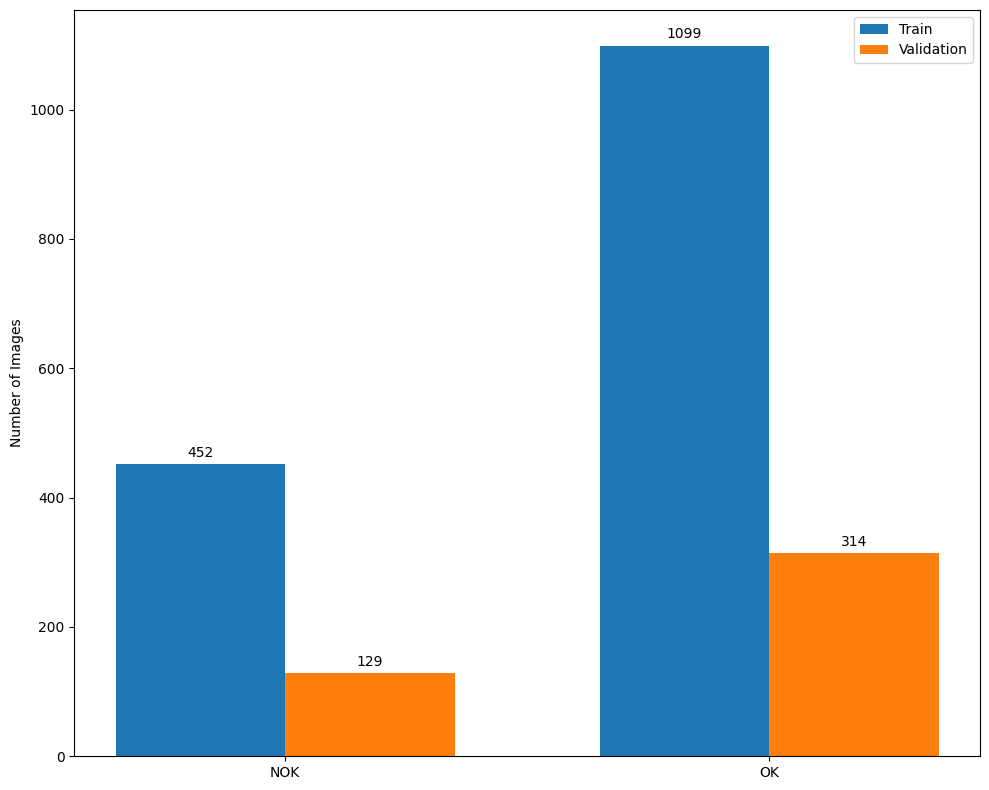

In [4]:
visualize_data(train_dir, val_dir)

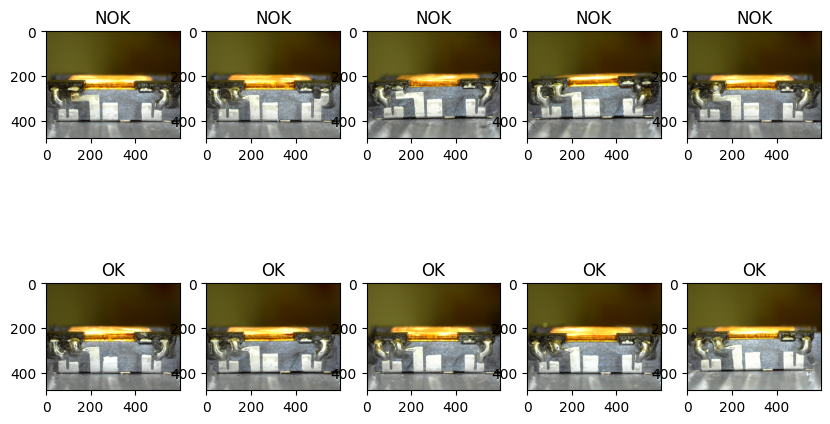

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("OK")

plt.show()

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1551 images belonging to 2 classes.


In [9]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 443 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 222 images belonging to 2 classes.


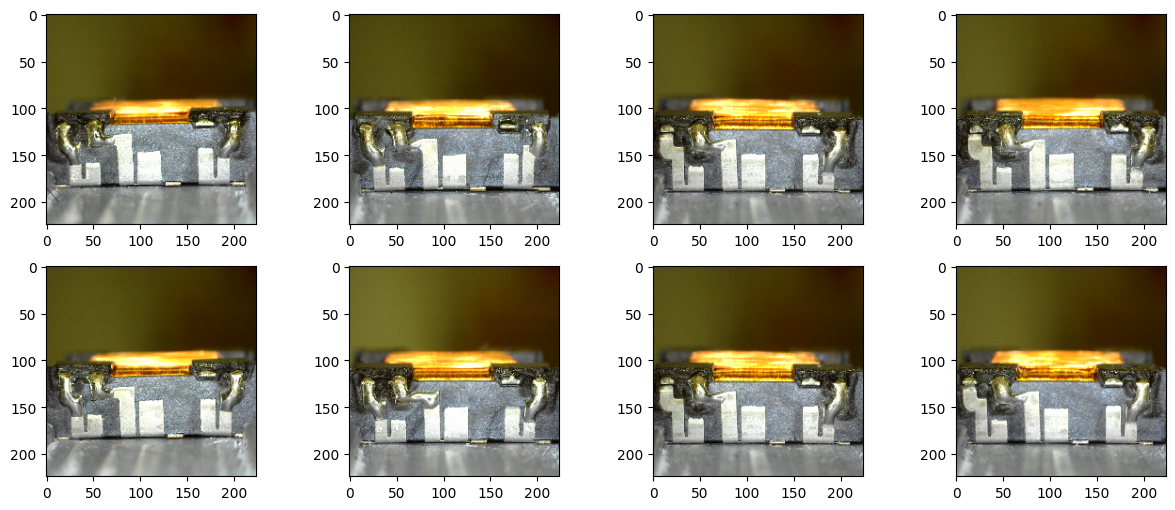

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 1.7157079646017699, 1: 0.7056414922656961}

In [13]:
base_model = MobileNetV2(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f192dfc3f10>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f192def9eb0>,Conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f192de41f10>,bn_Conv1,False
3,<keras.layers.activation.relu.ReLU object at 0x7f192de41e80>,Conv1_relu,False
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f192dddbf70>,expanded_conv_depthwise,False
...,...,...,...
151,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f192c664430>,Conv_1,False
152,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f192c65bac0>,Conv_1_bn,False
153,<keras.layers.activation.relu.ReLU object at 0x7f192c65bd90>,out_relu,False
154,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f192dfc3cd0>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [17]:
recall = Recall()
precision = Precision()

In [18]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb]
                  )

Epoch 1/10


2023-04-13 17:53:59.960345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7070 - recall: 0.8540 - precision: 0.7612

2023-04-13 17:54:32.023572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 41s 787ms/step - loss: 0.5856 - accuracy: 0.7070 - recall: 0.8540 - precision: 0.7612 - val_loss: 0.3905 - val_accuracy: 0.8534 - val_recall: 0.9456 - val_precision: 0.8607
Epoch 2/10
48/48 [==============================] - 34s 711ms/step - loss: 0.3866 - accuracy: 0.8427 - recall: 0.9362 - precision: 0.8562 - val_loss: 0.3310 - val_accuracy: 0.8726 - val_recall: 0.9692 - val_precision: 0.8654
Epoch 3/10
48/48 [==============================] - 34s 713ms/step - loss: 0.3510 - accuracy: 0.8558 - recall: 0.9454 - precision: 0.8645 - val_loss: 0.3099 - val_accuracy: 0.8750 - val_recall: 0.9830 - val_precision: 0.8601
Epoch 4/10
48/48 [==============================] - 34s 716ms/step - loss: 0.3149 - accuracy: 0.8769 - recall: 0.9583 - precision: 0.8794 - val_loss: 0.2846 - val_accuracy: 0.8990 - val_recall: 0.9731 - val_precision: 0.8947
Epoch 5/10
48/48 [==============================] - 34s 699ms/step - loss: 0.3021 - accuracy: 0.8802 - recall: 

In [21]:
len(base_model.layers)

154

In [ ]:
base_model.trainable = True
# Freeze the first 100 layers 
for layer in base_model.layers[:600]:
  layer.trainable = False

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [23]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f192dfc3f10>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f192def9eb0>,Conv1,True
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f192de41f10>,bn_Conv1,True
3,<keras.layers.activation.relu.ReLU object at 0x7f192de41e80>,Conv1_relu,True
4,<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f192dddbf70>,expanded_conv_depthwise,True
...,...,...,...
151,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f192c664430>,Conv_1,True
152,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f192c65bac0>,Conv_1_bn,True
153,<keras.layers.activation.relu.ReLU object at 0x7f192c65bd90>,out_relu,True
154,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f192dfc3cd0>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

156

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model_2.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb]
                   )

Epoch 1/100


2023-04-13 17:59:53.731969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.8598 - recall: 0.9288 - precision: 0.8963

2023-04-13 18:01:31.766387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


48/48 [==============================] - 107s 2s/step - loss: 0.3275 - accuracy: 0.8598 - recall: 0.9288 - precision: 0.8963 - val_loss: 0.4335 - val_accuracy: 0.7981 - val_recall: 1.0000 - val_precision: 0.7789 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 100s 2s/step - loss: 0.0390 - accuracy: 0.9928 - recall: 0.9972 - precision: 0.9926 - val_loss: 0.2450 - val_accuracy: 0.8798 - val_recall: 0.9932 - val_precision: 0.8592 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 101s 2s/step - loss: 0.0118 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.8990 - val_recall: 0.9898 - val_precision: 0.8818 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 100s 2s/step - loss: 0.0077 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.1748 - val_accuracy: 0.9303 - val_recall: 0.9862 - val_precision: 0.9196 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 98s 2s/step

Epoch 36/100
48/48 [==============================] - 99s 2s/step - loss: 0.0022 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0507 - val_accuracy: 0.9856 - val_recall: 0.9864 - val_precision: 0.9932 - lr: 0.0010
Epoch 37/100
48/48 [==============================] - 98s 2s/step - loss: 0.0012 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0493 - val_accuracy: 0.9832 - val_recall: 0.9864 - val_precision: 0.9898 - lr: 0.0010
Epoch 38/100
48/48 [==============================] - 97s 2s/step - loss: 0.0015 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9856 - val_recall: 0.9866 - val_precision: 0.9933 - lr: 0.0010
Epoch 39/100
48/48 [==============================] - 98s 2s/step - loss: 0.0025 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9856 - val_recall: 0.9898 - val_precision: 0.9898 - lr: 2.0000e-04
Epoch 40/100
48/48 [============================

48/48 [==============================] - 101s 2s/step - loss: 0.0017 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0362 - val_accuracy: 0.9856 - val_recall: 0.9897 - val_precision: 0.9897 - lr: 8.0000e-06
Epoch 71/100
48/48 [==============================] - 100s 2s/step - loss: 0.0015 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0358 - val_accuracy: 0.9856 - val_recall: 0.9899 - val_precision: 0.9899 - lr: 1.6000e-06
Epoch 72/100
48/48 [==============================] - 100s 2s/step - loss: 0.0025 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9880 - val_recall: 0.9898 - val_precision: 0.9932 - lr: 1.6000e-06
Epoch 73/100
48/48 [==============================] - 101s 2s/step - loss: 0.0021 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9856 - val_recall: 0.9898 - val_precision: 0.9898 - lr: 1.6000e-06
Epoch 74/100
48/48 [=========================

In [30]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

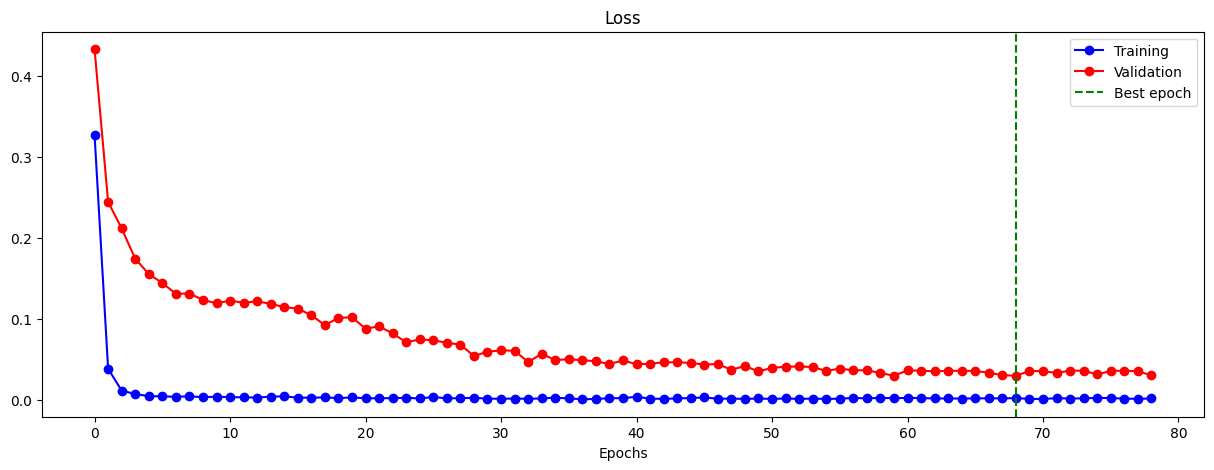

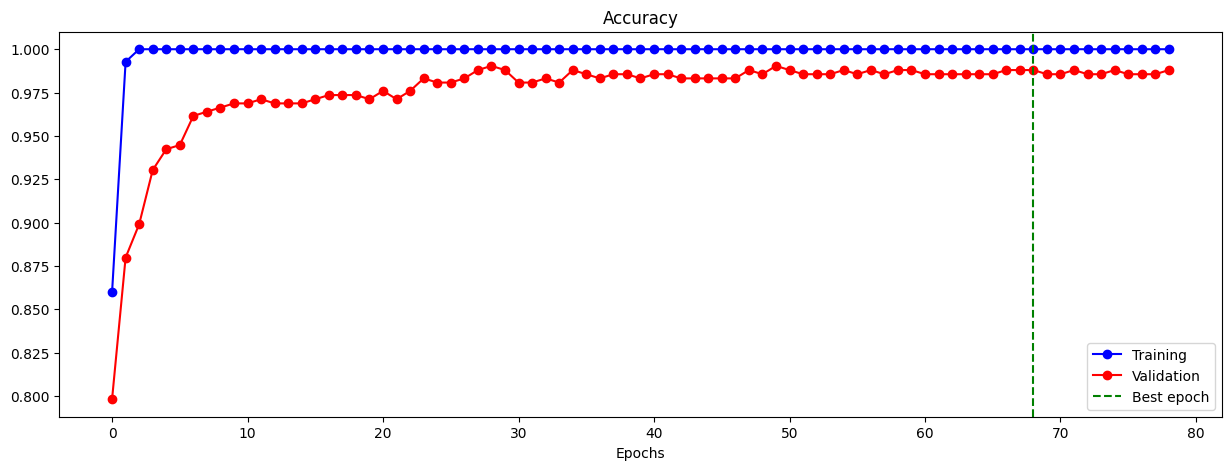

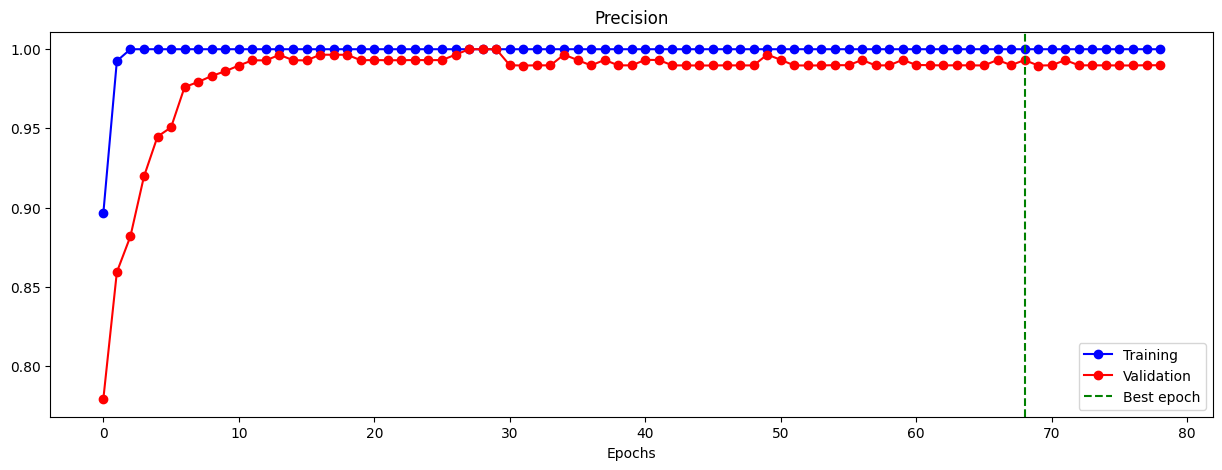

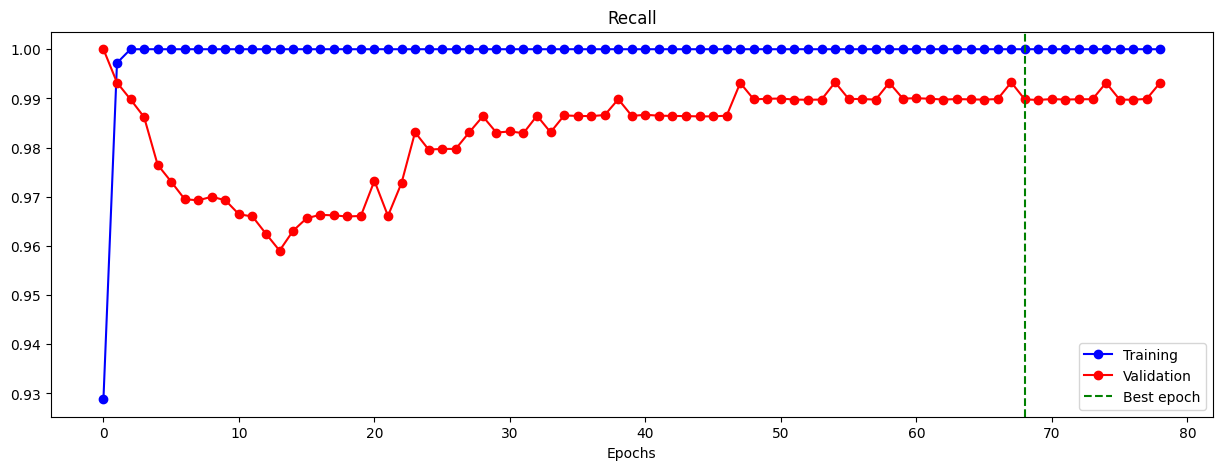

In [31]:
visualize_training_results(history)

In [11]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')

    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


2023-04-13 20:11:58.181981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 5s 566ms/step


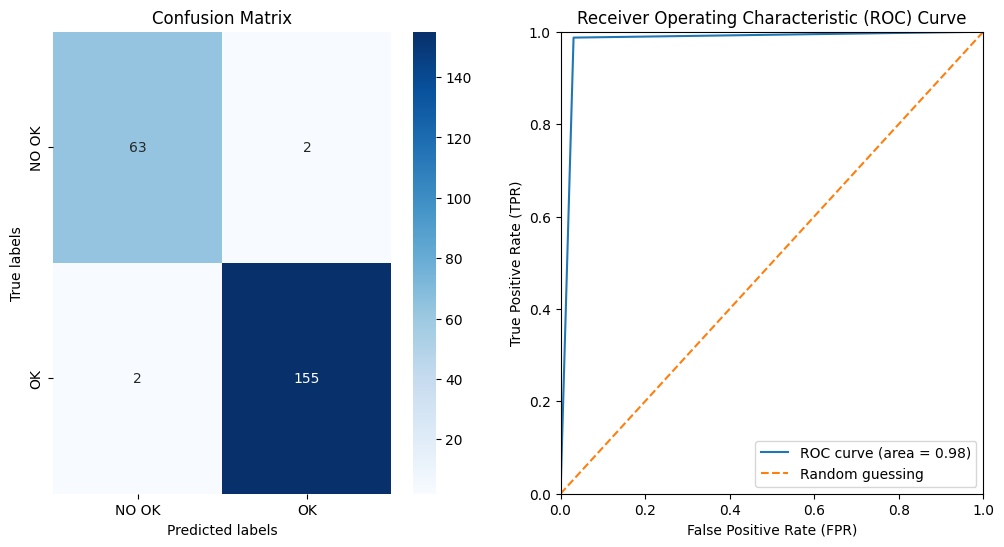

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        65
           1       0.99      0.99      0.99       157

    accuracy                           0.98       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.98      0.98      0.98       222



In [33]:
plot_metrics(model, test_data)

In [12]:
from keras.models import load_model

In [13]:
checkpoint_model = load_model('model_2.h5')

In [14]:
checkpoint_model

2023-05-03 19:10:03.967620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 5s 591ms/step


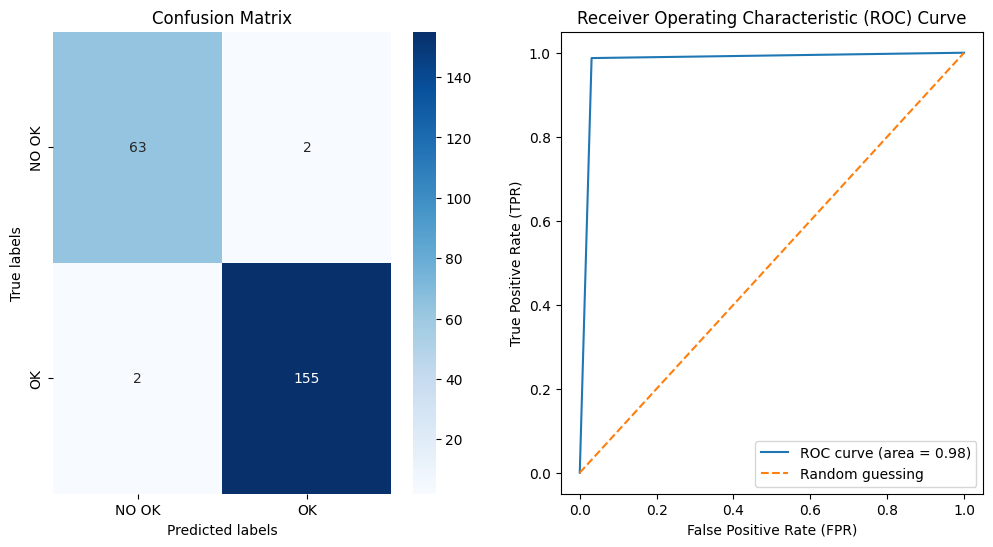

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        65
           1       0.99      0.99      0.99       157

    accuracy                           0.98       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.98      0.98      0.98       222



In [15]:
plot_metrics(checkpoint_model, test_data)

In [34]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  68
Best loss:  0.002611065050587058
Best accuracy:  1.0
Best recall:  1.0
Best precision:  1.0
Best val_loss:  0.03020561672747135
Best val_accuracy:  0.9879807829856873
Best val_recall:  0.9897959232330322
Best val_precision:  0.9931740760803223
